In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import visualization
import datahandler

In [2]:
participant_code = 'C1K4L9S8'
load_state_data = False
data_path = './participant data/'
trimmed_data, sections = datahandler.load_participant(participant_code, data_path, load_state_data)

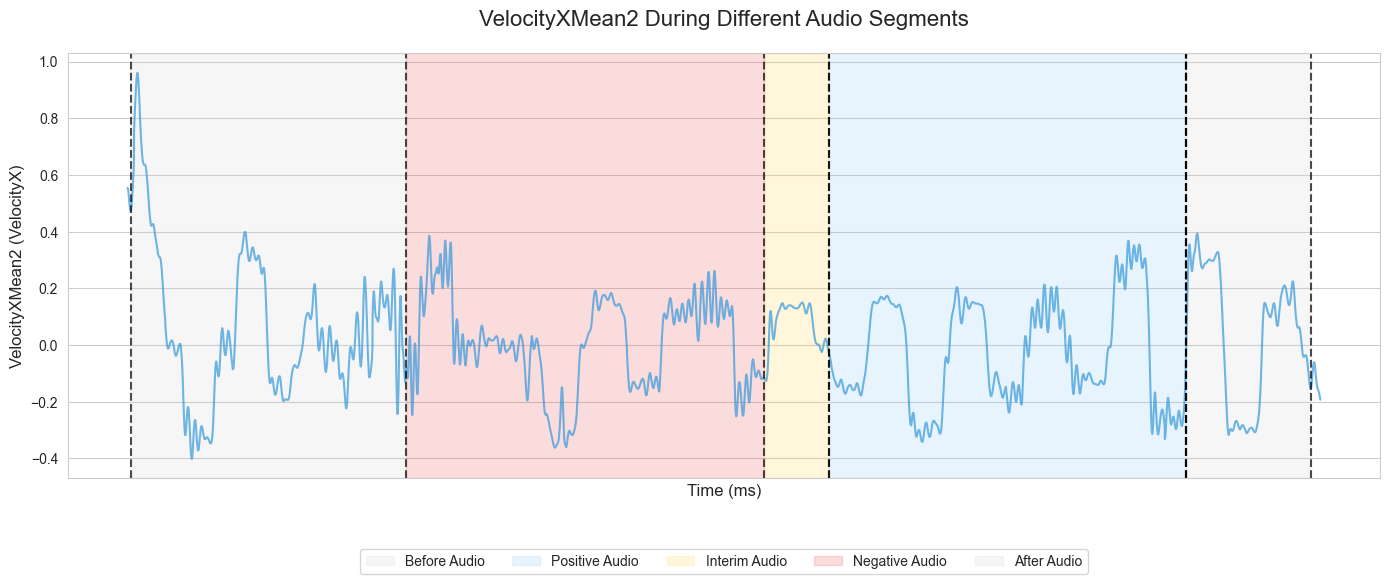

In [3]:
trimmed_data['VelocityXMean2'] = trimmed_data['VelocityX'].rolling(window=10000, min_periods=1000).mean()

visualization.plot_column(trimmed_data, 'VelocityXMean2', 'VelocityX', sections=sections)


In [4]:

  # def cohen_d(x, y):
  #   nx, ny = len(x), len(y)
  #   pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 +
  #                         (ny - 1) * np.std(y, ddof=1)**2) / (nx + ny - 2))
  #   return (np.mean(x) - np.mean(y)) / pooled_std




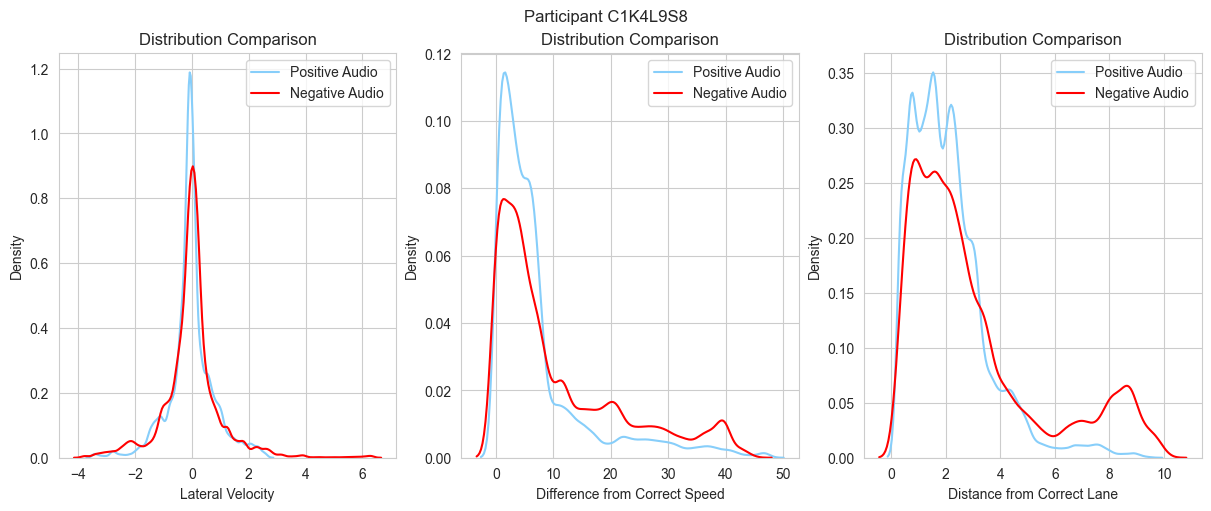

In [5]:
_ = visualization.compare_perf_kdes(participant_code, trimmed_data, sections=sections)


### Analyze distributions

In [6]:
datahandler.get_statistics(trimmed_data, sections=sections)

(np.float64(2.098856940686032),
 np.float64(1.430441783059244),
 np.float64(12.607055256208122),
 np.float64(3.02714215816653),
 np.float64(2.4753333380021627),
 np.float64(64.44555011391122))

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
37229.4071
G9K4W1Z0 OK
I8L4N6G7 OK
7461.6038
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
L0S1Z2I3 OK
L1N3B5O2 OK
17154.8936
M0R6U5F9 OK
M4H6R2W9 OK
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
R0V9G1L4 FAIL
U6O5V2T9 OK
V9L0P2K7 OK
X5Q0G4J2 OK
15687.0263
Z6A2W1E8 OK


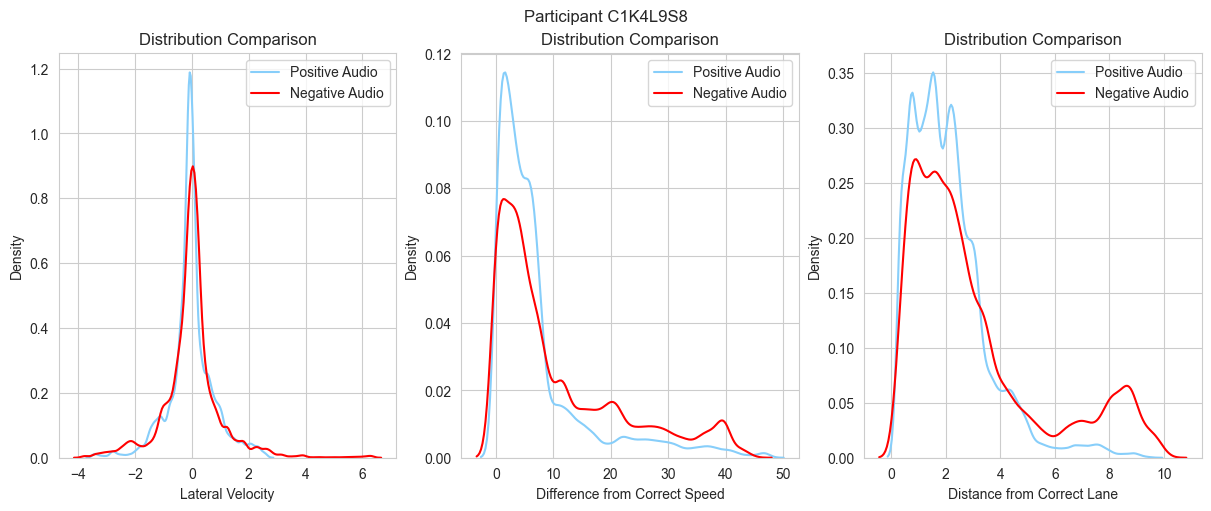

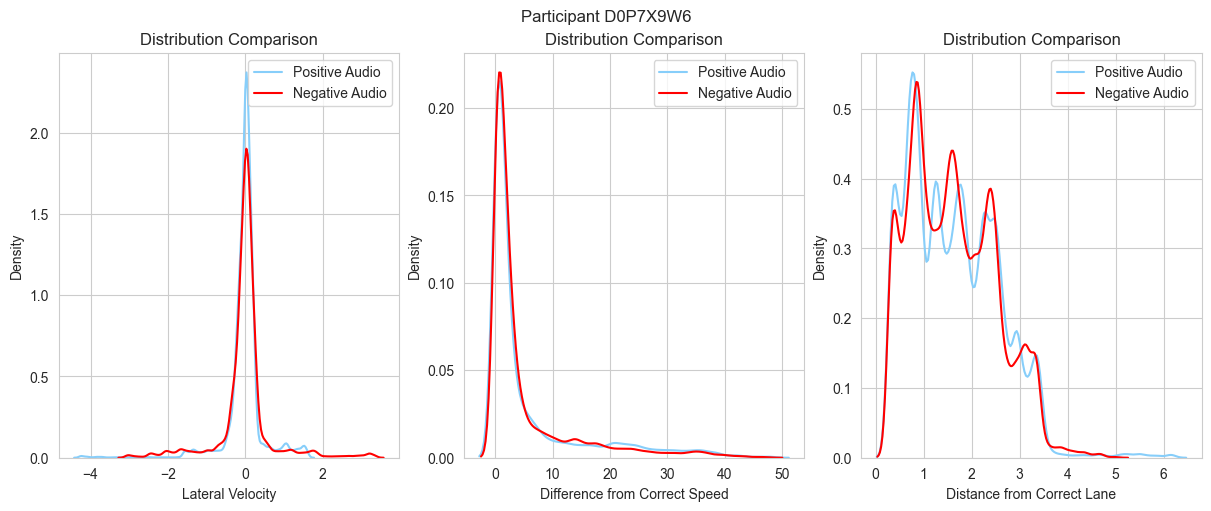

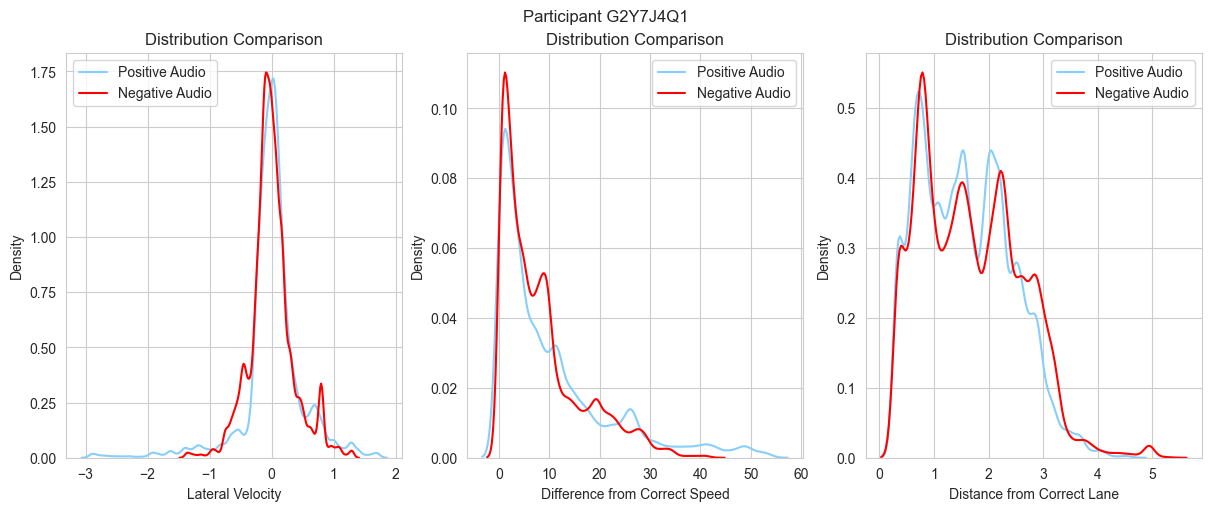

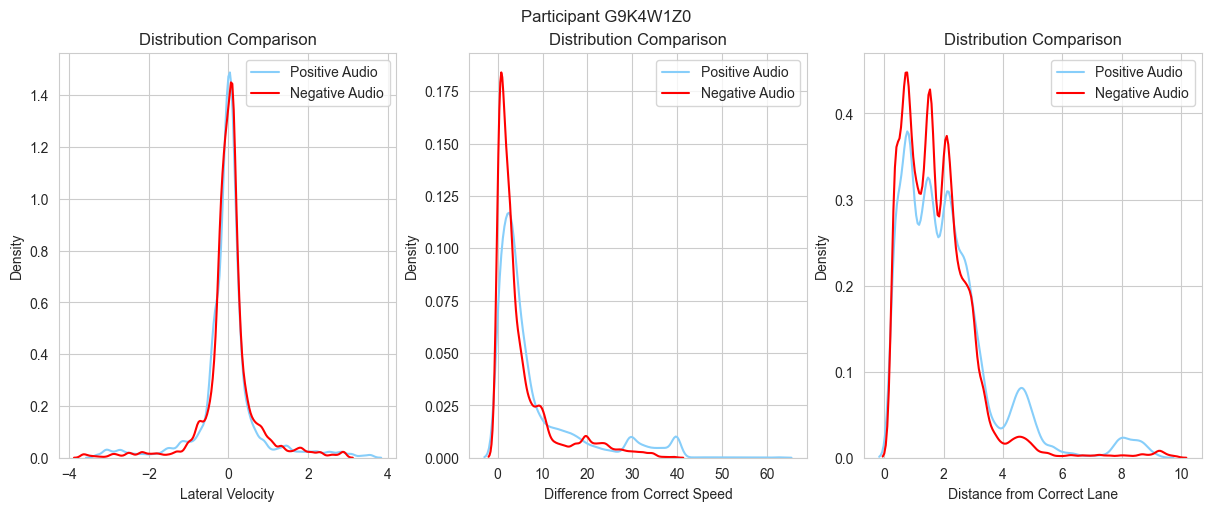

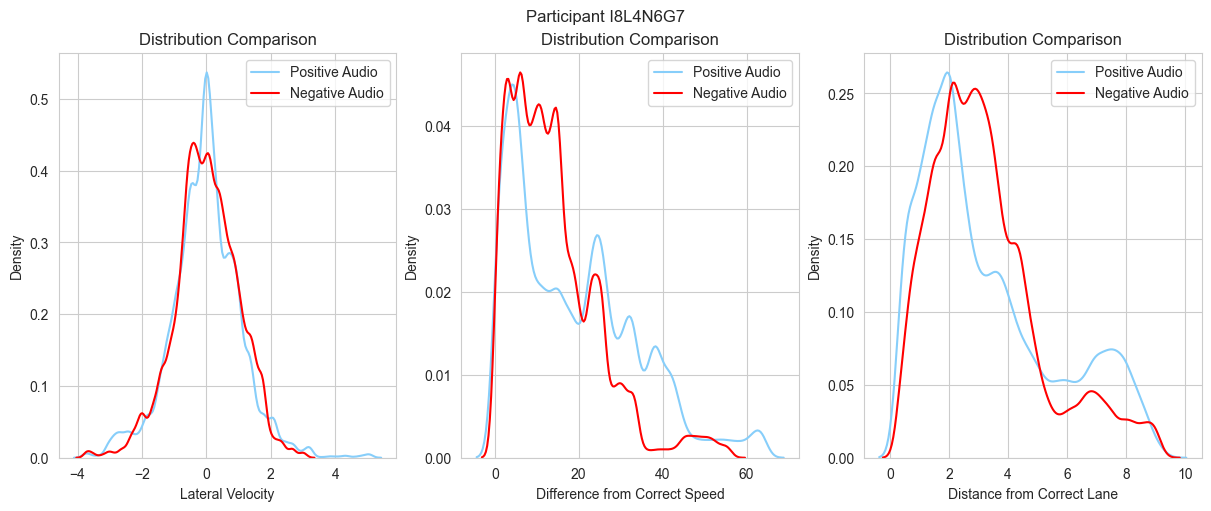

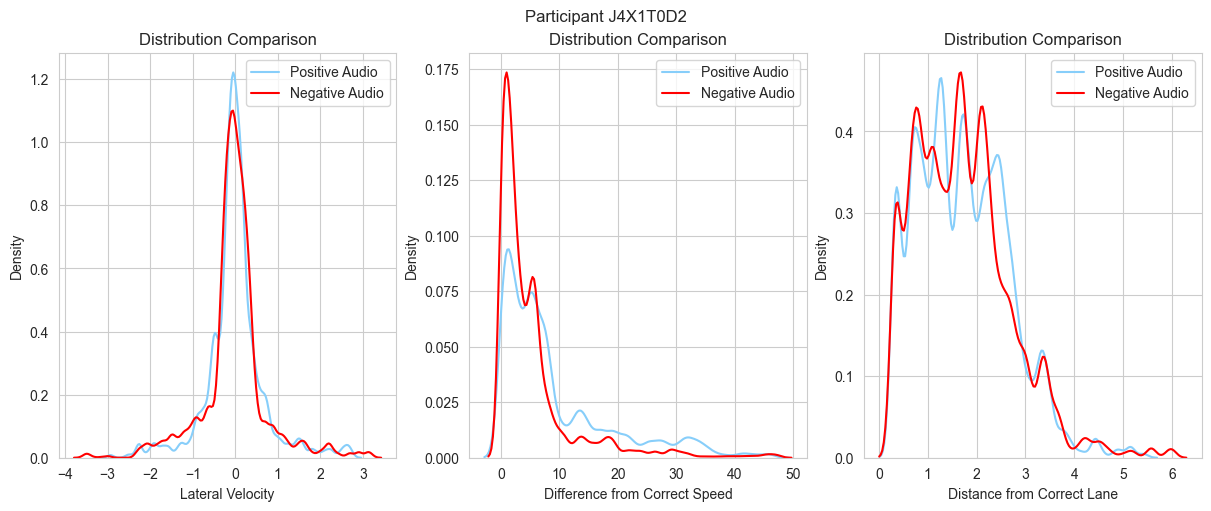

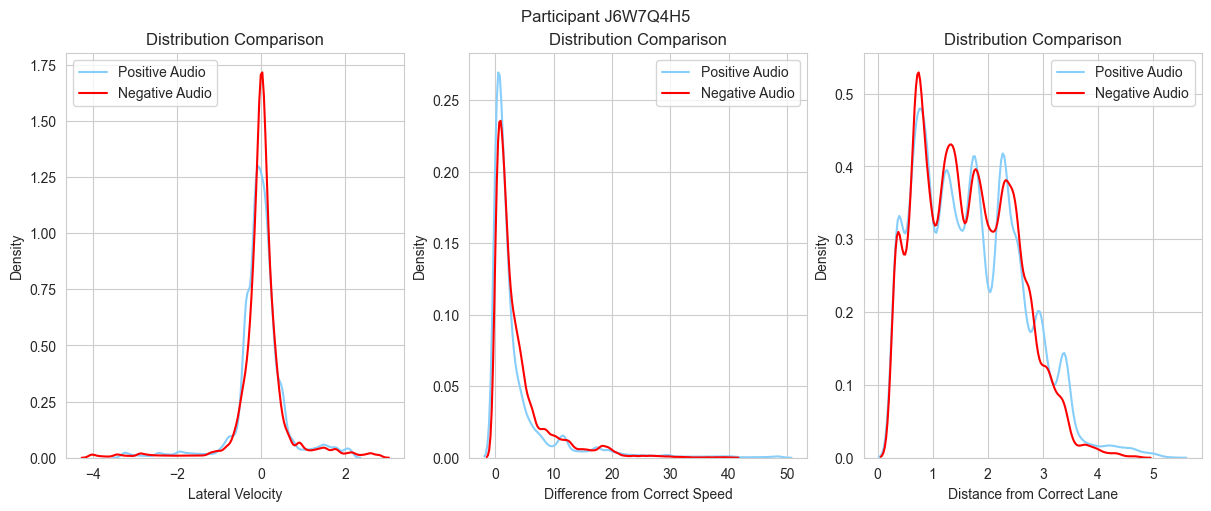

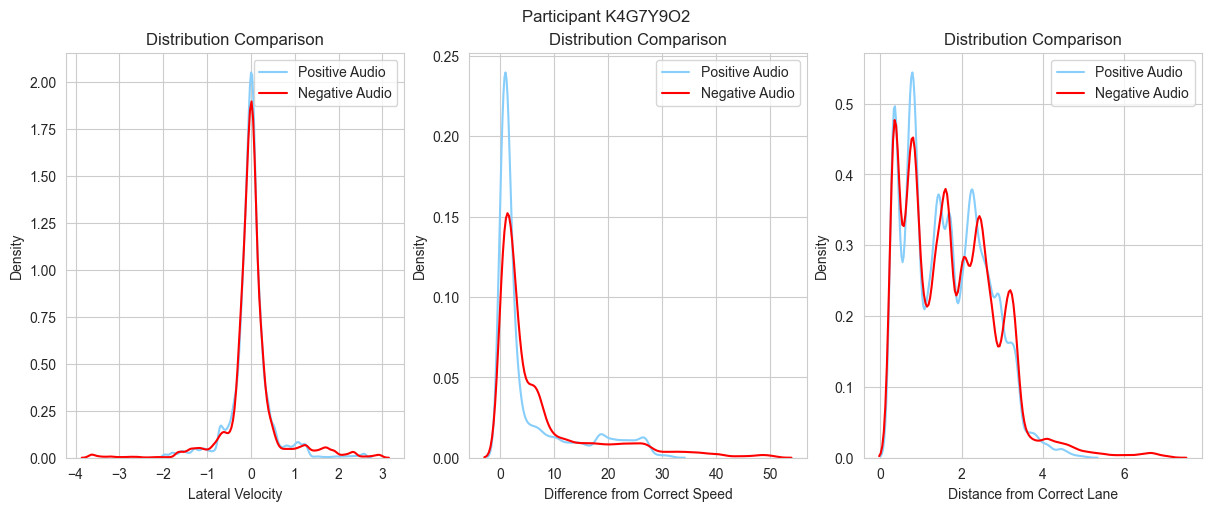

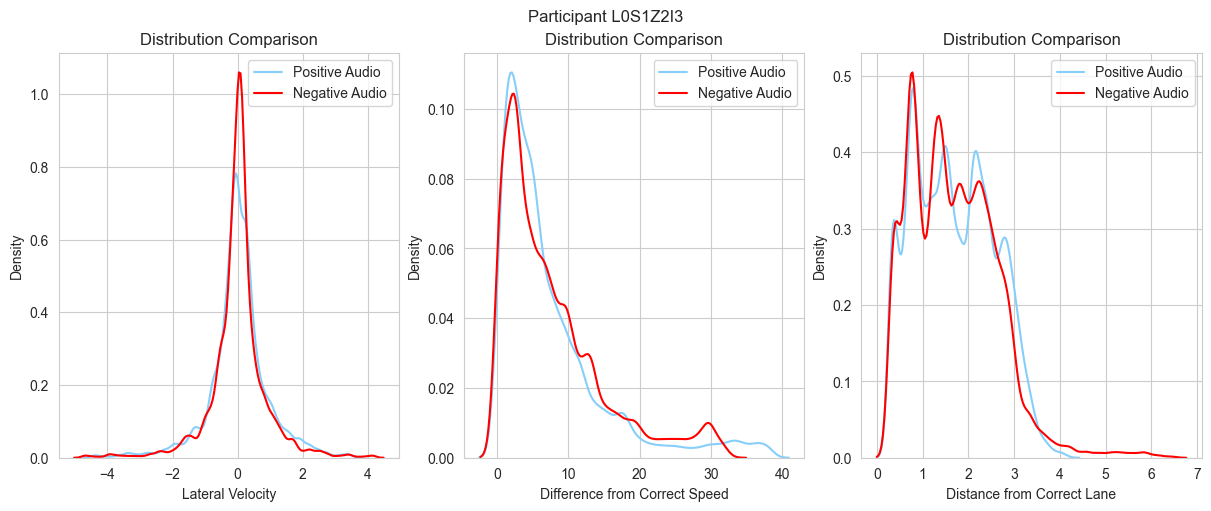

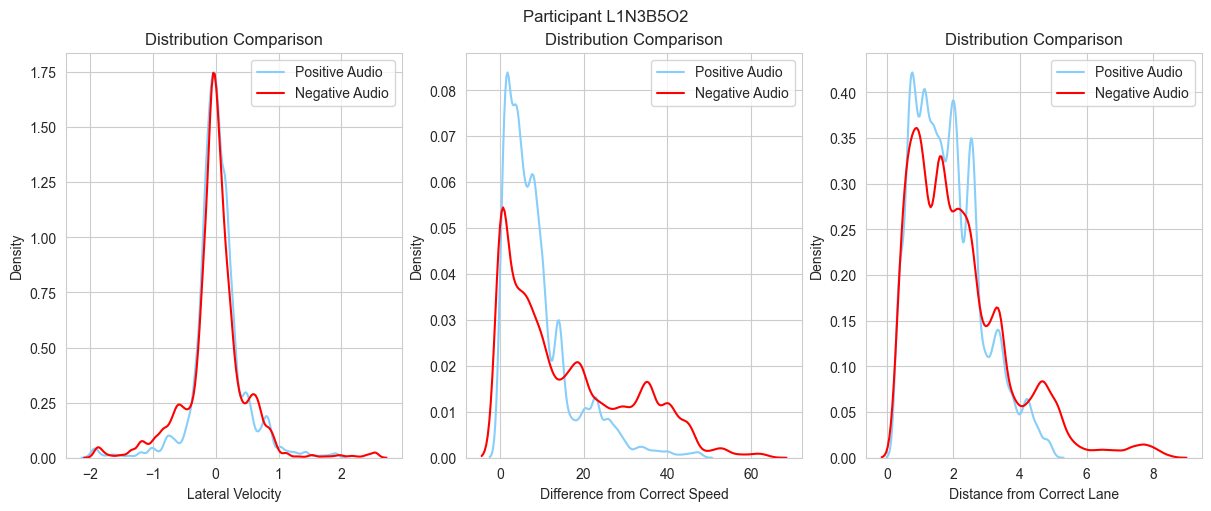

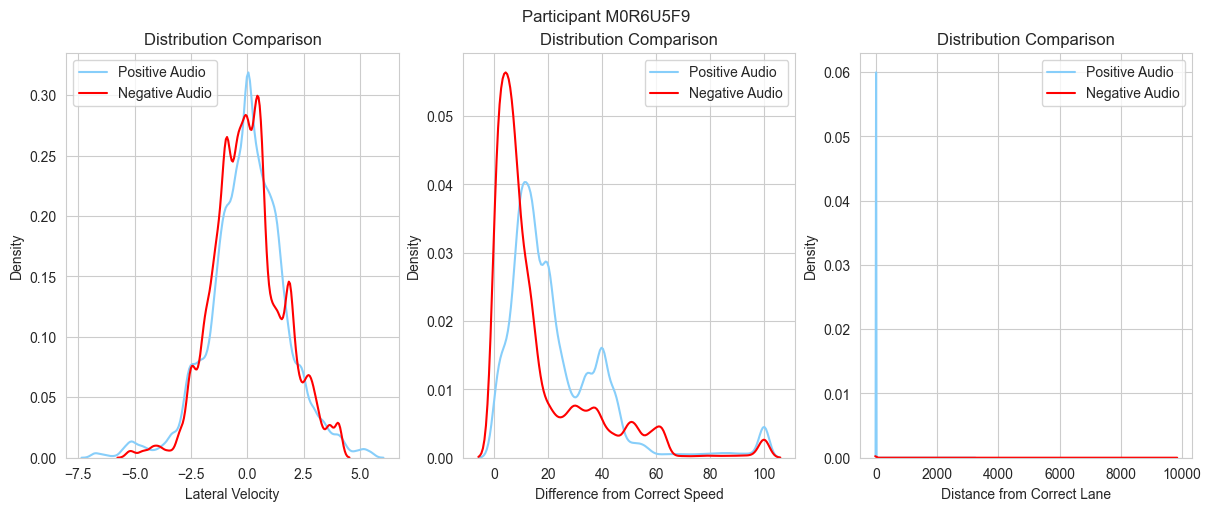

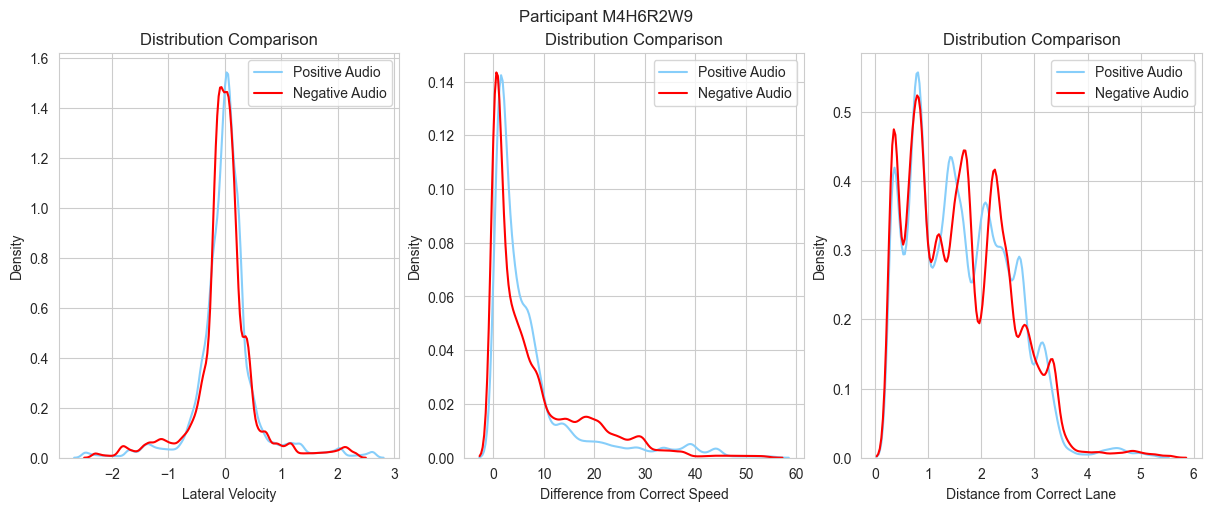

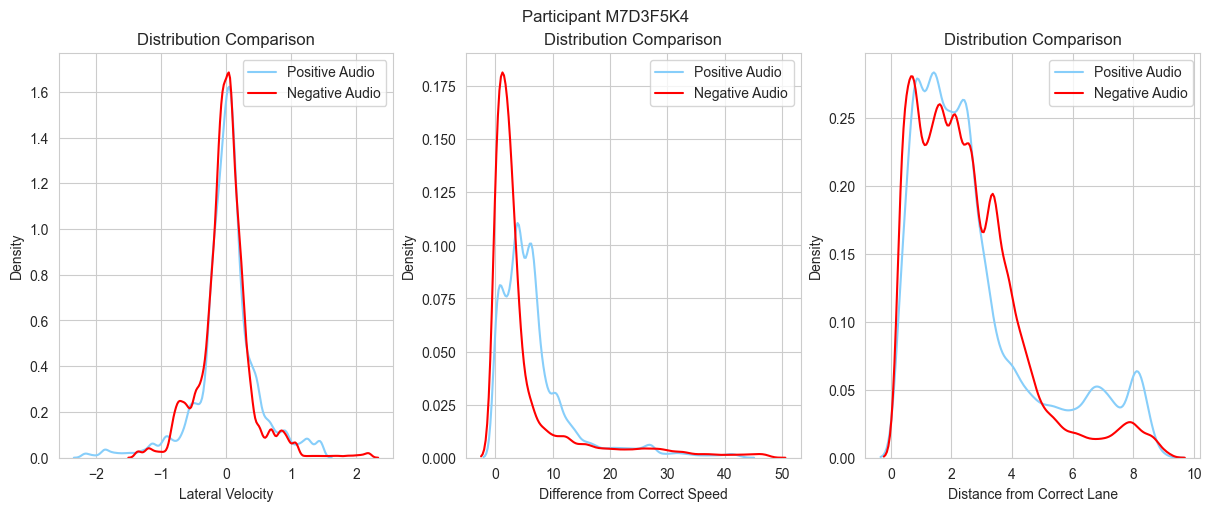

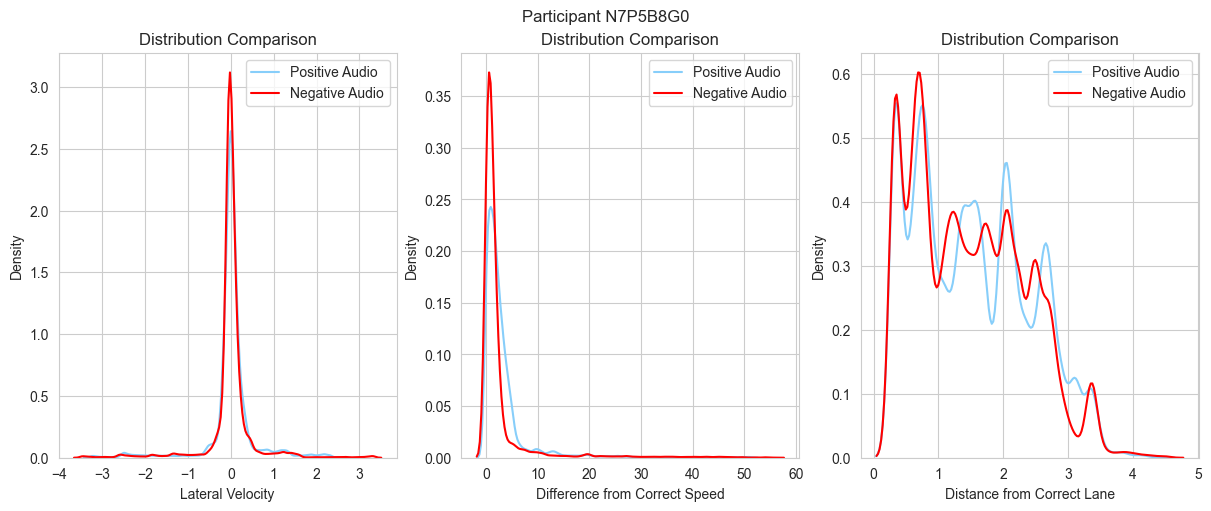

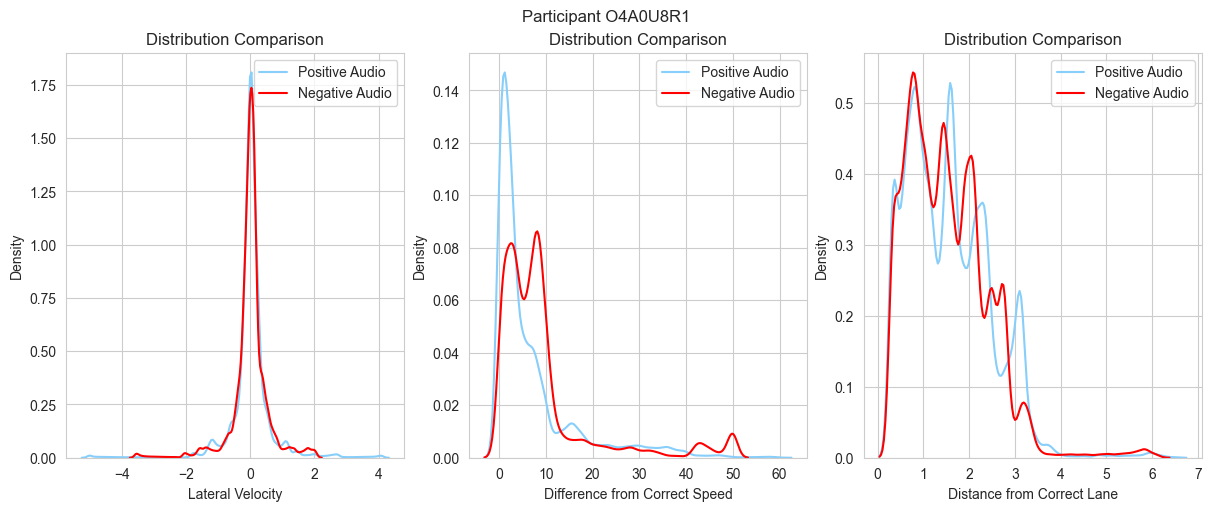

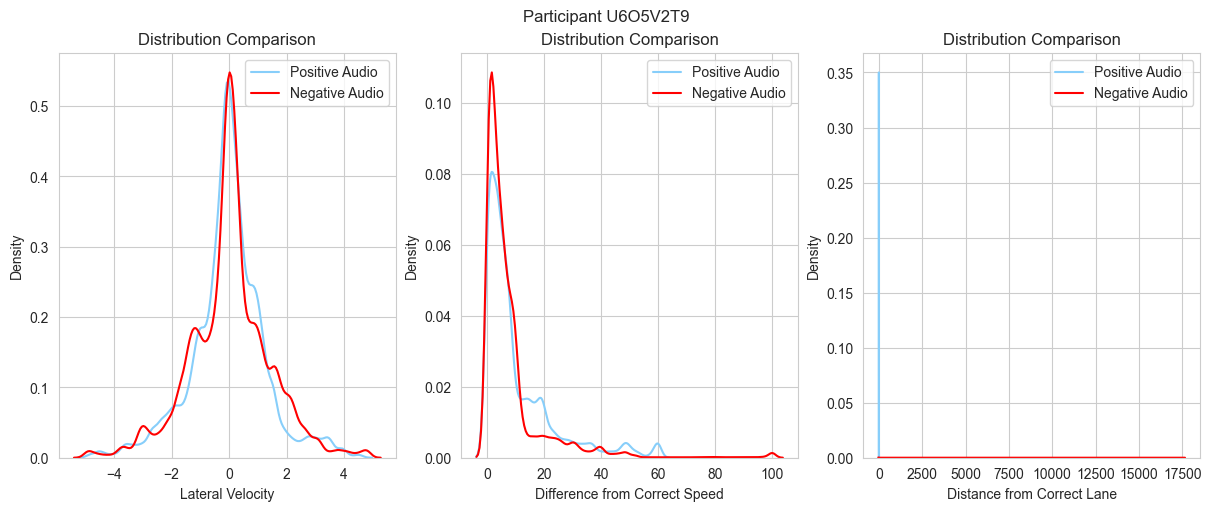

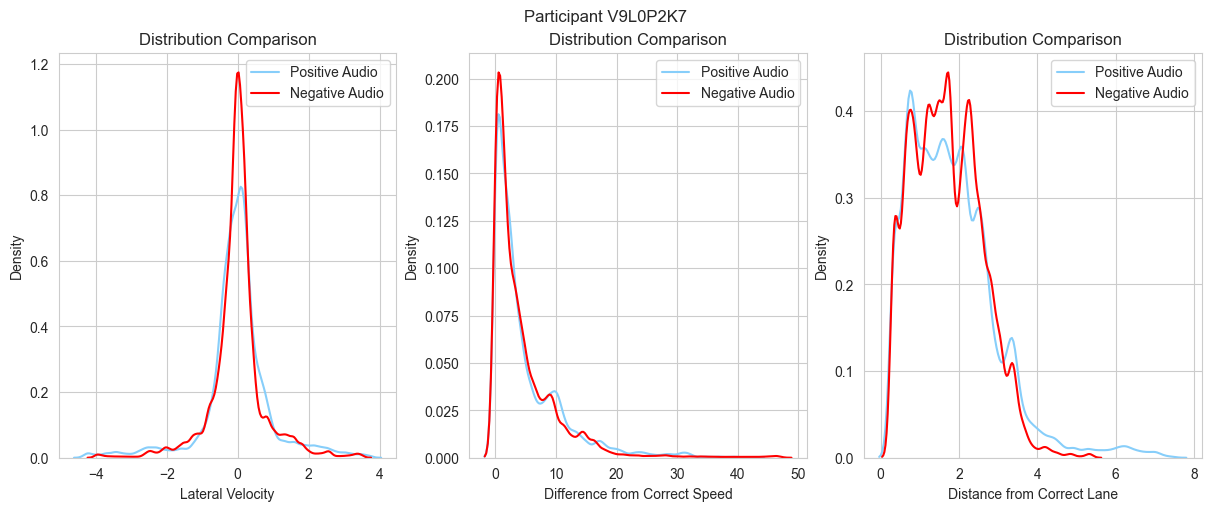

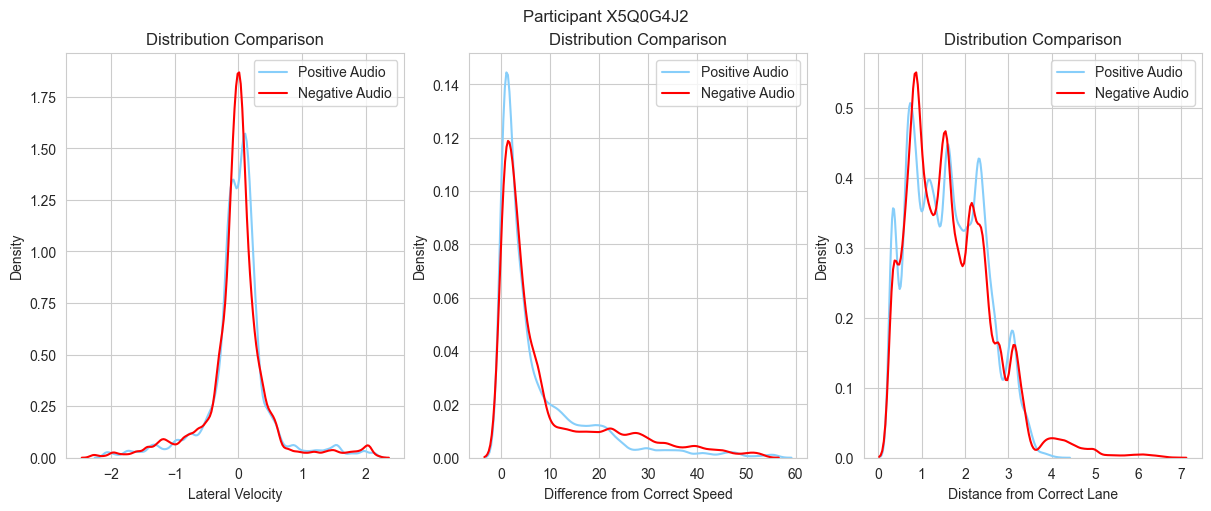

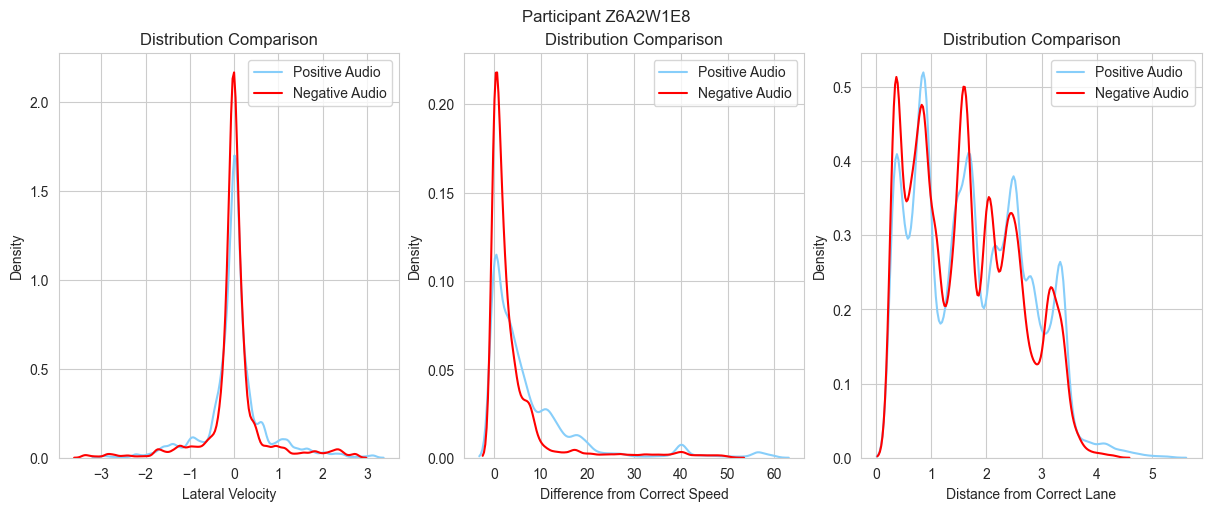

In [8]:
import os


for root, dirs, files in os.walk(data_path):
    identifiers = [f.replace('.csv','') for f in files if f != "W1D9N0B8.csv" and f != 'M3A2H7Q4.csv']
print(identifiers)

intense_stats = []
calm_stats = []
for id in identifiers:
    load_state_data = False

    try:
        trimmed_data, sections = datahandler.load_participant(id, data_path, load_state_data)
        print(f'{id} OK')
    except:
        print(f'{id} FAIL')
        continue
    
     
    trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()
    trimmed_data['DistanceToTargetSpeed_Mean'] = trimmed_data['DistanceToTargetSpeed'].rolling(window=10000).mean()
    trimmed_data['VelocityX_Mean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    
    visualization.compare_perf_kdes(id, trimmed_data, sections=sections)

    pairs = [
    ('VelocityX', 'Lateral Velocity'),
    ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
    ('DistanceToTargetPosition','Distance to Correct Lane')
    ]

    for (col1, col2) in pairs:
        mean1, std1, mom1, mean2, std2, mom2 = datahandler.get_statistics(trimmed_data, col1, col2, sections=sections)
        calm_stats.append((mean1, std1, mom1))
        intense_stats.append((mean2, std2, mom2))


In [9]:
velocity_x_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % 3 == 0]
speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % 3 == 1]
position_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % 3 == 2]
velocity_x_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % 3 == 0]
speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % 3 == 1]
position_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % 3 == 2]

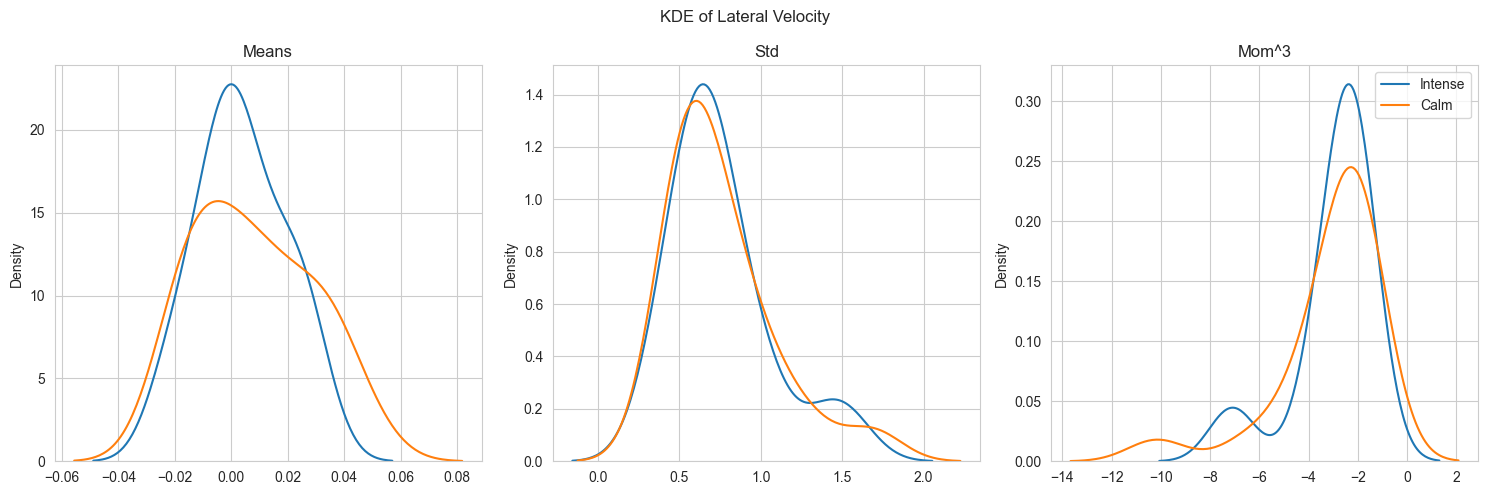

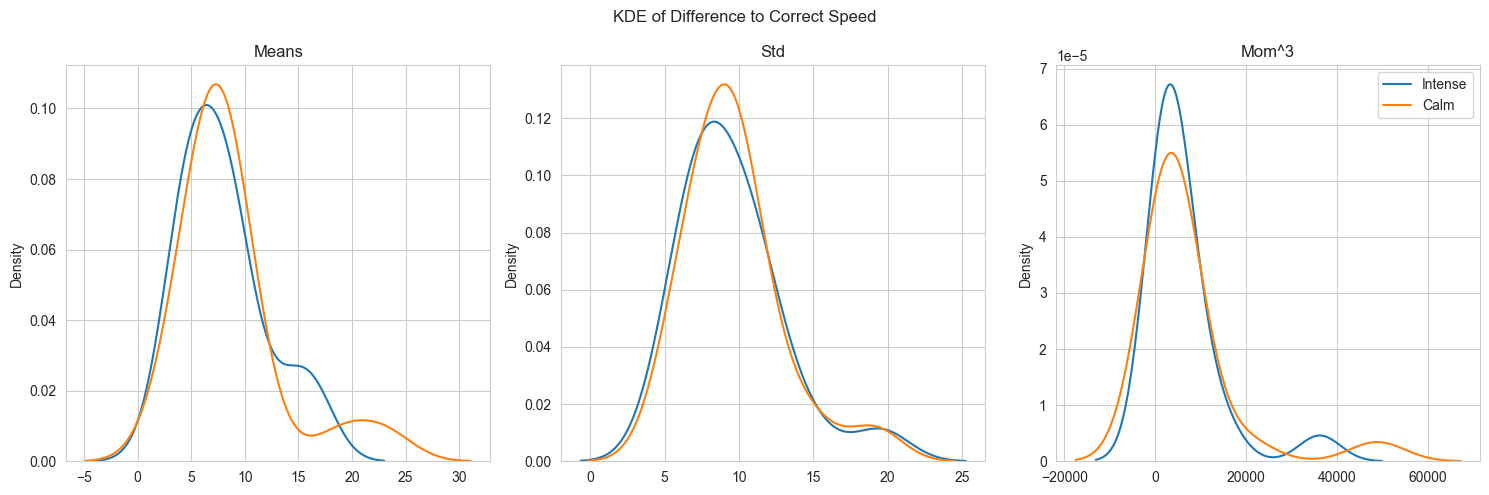

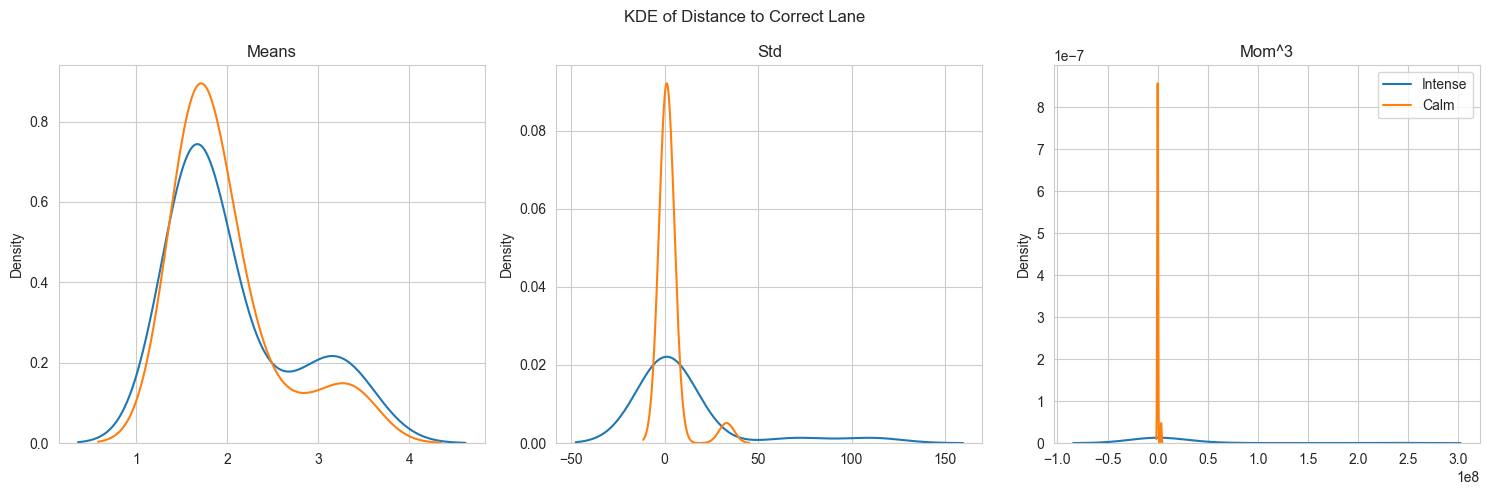

In [48]:


datasets = [[velocity_x_intense, velocity_x_calm],
           [speed_intense, speed_calm],
           [position_intense, position_calm]]
titles = ['Lateral Velocity', 'Difference to Correct Speed', 'Distance to Correct Lane']   

for j, (intense, calm) in enumerate(datasets):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        sns.kdeplot([x[i] for x in intense], label=f'Intense', ax=axes[i])
        sns.kdeplot([x[i] for x in calm], label=f'Calm', ax=axes[i])
        axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
    plt.suptitle(f'KDE of {titles[j]}')
    plt.tight_layout()
    plt.savefig('kde_lateral_velocity_statistics.png', dpi=300)
    plt.legend()
    plt.show()


In [56]:
import scipy.stats as stats
from scipy.stats import ttest_rel

for j, (intense, calm) in enumerate(datasets):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')



T-test results for Lateral Velocity, intense vs calm:
Means: 0.516397629427266
STDs: 0.978759613223566
Mom^3s: 0.3456505247982654

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.40108382894776573
STDs: 0.822953975660763
Mom^3s: 0.5416353239992819

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.3784399112980036
STDs: 0.21229321945311058
Mom^3s: 0.247360438668722


Text(0.5, 1.0, 'Distance to Target Speed Means')

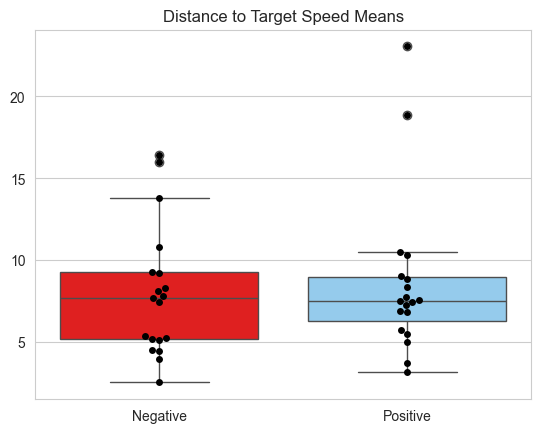

In [18]:
sns.boxplot({'Negative':[x for x,_,_ in speed_intense],'Positive':[x for x,_,_ in speed_calm]}, palette=['red', 'lightskyblue'])
sns.swarmplot({'Negative':[x for x,_,_ in speed_intense],'Positive':[x for x,_,_ in speed_calm]}, color='black')
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance to Target Speed Means')

In [52]:
import scipy.stats as stats
from scipy.stats import ttest_rel
print(ttest_rel([x for x,_,_ in speed_intense],[x for x,_,_ in speed_calm]))
print(ttest_rel([x for _,x,_ in speed_intense],[x for _,x,_ in speed_calm]))
print(ttest_rel([x for _,_,x in speed_intense],[x for _,_,x in speed_calm]).pvalue)

TtestResult(statistic=np.float64(-0.8600276181260718), pvalue=np.float64(0.40108382894776573), df=np.int64(18))
TtestResult(statistic=np.float64(-0.22703643435826892), pvalue=np.float64(0.822953975660763), df=np.int64(18))
0.5416353239992819


Text(0.5, 1.0, 'Distance to Target Lane Means')

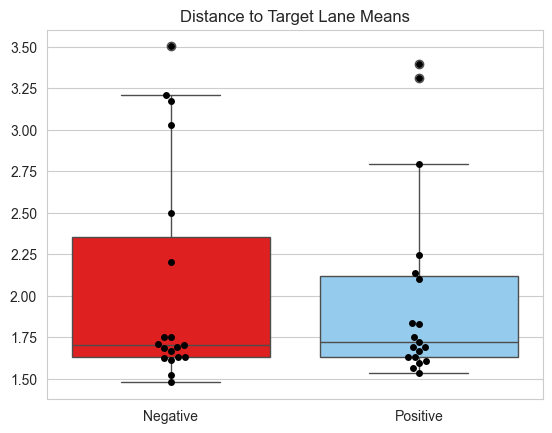

In [13]:
sns.boxplot({'Negative':[x for x,_,_ in position_intense],'Positive':[x for x,_,_ in position_calm]}, palette=['red', 'lightskyblue'])
sns.swarmplot({'Negative':[x for x,_,_ in position_intense],'Positive':[x for x,_,_ in position_calm]}, color='black')
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance to Target Lane Means')

Text(0.5, 1.0, 'Distance to Target Lane STDs')

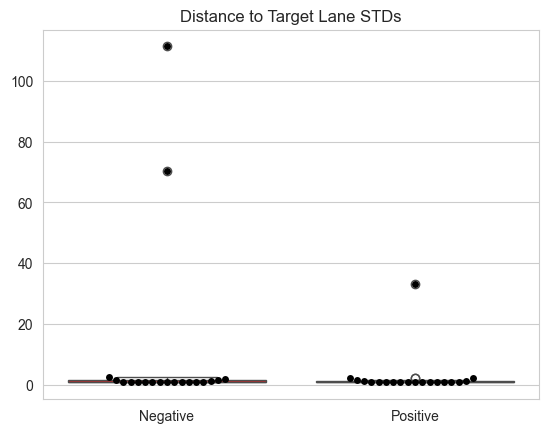

In [49]:
sns.boxplot({'Negative':[x for _,x,_ in position_intense ],'Positive':[x for _,x,_ in position_calm ]}, palette=['red', 'lightskyblue'])
sns.swarmplot({'Negative':[x for _,x,_ in position_intense ],'Positive':[x for _,x,_ in position_calm ]}, color='black')
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance to Target Lane STDs')

Text(0.5, 1.0, 'Distance To Target Position MOM3')

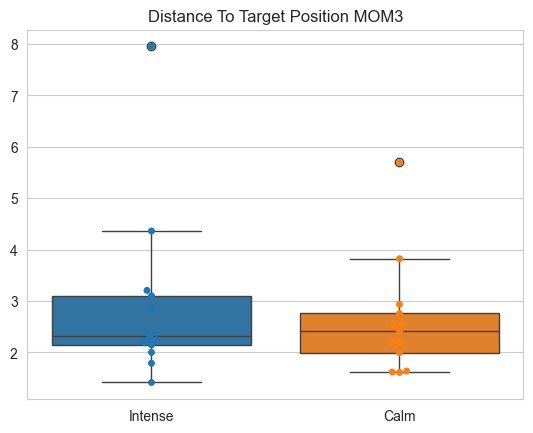

In [15]:
sns.boxplot({'Intense':[x for _,_,x in position_intense if x < 10],'Calm':[x for _,_,x in position_calm if x < 10]})
sns.swarmplot({'Intense':[x for _,_,x in position_intense if x < 10],'Calm':[x for _,_,x in position_calm if x < 10]})
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance To Target Position MOM3')

In [51]:
import scipy.stats as stats
from scipy.stats import ttest_rel

print(ttest_rel([x for x,_,_ in position_intense],[x for x,_,_ in position_calm]))
print(ttest_rel([x for _,x,_ in position_intense],[x for _,x,_ in position_calm]))
print(ttest_rel([x for _,_,x in position_intense],[x for _,_,x in position_calm]))
# [x for _,_,x in position_intense if x < 10]

TtestResult(statistic=np.float64(0.9030232173024636), pvalue=np.float64(0.3784399112980036), df=np.int64(18))
TtestResult(statistic=np.float64(1.2932005985716424), pvalue=np.float64(0.21229321945311058), df=np.int64(18))
TtestResult(statistic=np.float64(1.195616512049427), pvalue=np.float64(0.247360438668722), df=np.int64(18))


Text(0.5, 1.0, 'Distance from Target Speed Means')

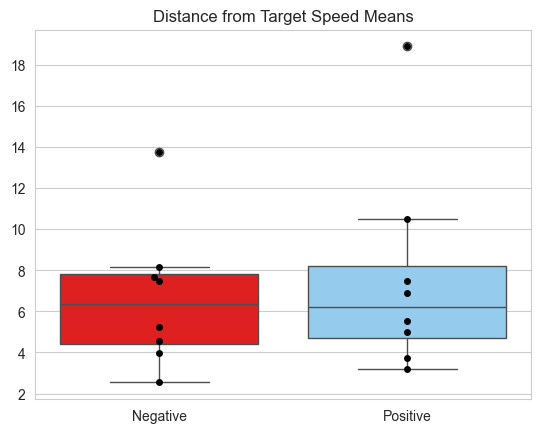

In [ ]:
sns.boxplot({'Negative':[x for x,_,_ in speed_intense],'Positive':[x for x,_,_ in speed_calm]}, palette=['red', 'lightskyblue'])
sns.swarmplot({'Negative':[x for x,_,_ in speed_intense],'Positive':[x for x,_,_ in speed_calm]}, color='black')
# sns.kdeplot([x for x,_,_ in position_calm], label='Calm Velocity X')
# plt.legend()
plt.title('Distance from Target Speed Means')